In [1]:
import xarray as xr
import harp 
import contextily as cx
import numpy as np
import os
from os.path import join
import netCDF4 as nc
import matplotlib.pyplot as plt
import glob
from glob import iglob
import pandas as pd
import warnings
import time
import datetime
import geopandas as gpd
import netCDF4 as nc
import rasterio
from shapely.geometry import mapping
import rioxarray as rio
import imageio
warnings.filterwarnings('ignore')

In [22]:
start_date = datetime.datetime(2021,6,1)
end_date = datetime.datetime(2021,6,8)
date_list = []
while start_date <= end_date:
    date_list.append(start_date.strftime('%Y%m%d'))
    start_date += datetime.timedelta(1)

In [5]:
# Read India Shapefile 
in_shp = gpd.read_file('D:\shp\Delhi_Boundary.shp',crs="epsg:4326")
ward_shp = gpd.read_file('D:\shp\Delhi_Wards.shp',crs="epsg:4326")

In [25]:
input_file_path='D:\\Ozone\\Lockdown\\'
out_prepro_path='D:\\Ozone\\Lockdown\\Preprocessed\\'
for i in range(0,len(date_list)):
    file_input = sorted(glob.glob(join(input_file_path,'S5P_OFFL_L2__O3_____'+date_list[i]+'*.nc')))
    
    for j in range(len(file_input)):
        converted_o3 = harp.import_product(file_input[j],\
                                          operations = "O3_column_number_density_validity>50; \
                                          derive(O3_column_number_density [mol/m2]); \
                                          derive(datetime_stop {time} );\
                                          latitude > 28.4 [degree_north] ; latitude < 28.9 [degree_north] ; \
                                          longitude > 76.8 [degree_east] ; longitude < 77.4 [degree_east];\
                                          bin_spatial(50,28.4,0.01,60,76.8,0.01);\
                                          derive(latitude {latitude}) ; derive(longitude {longitude}) ;\
                                          keep(latitude,latitude_bounds,longitude,longitude_bounds,\
                                          O3_column_number_density)")
        harp.export_product(converted_o3,join(out_prepro_path,file_input[j].split('\\')[-1]),file_format='netcdf')
        converted_o3 = None
        print('product', file_input[j],'pre-processed')


product D:\Ozone\Lockdown\S5P_OFFL_L2__O3_____20210524T070649_20210524T084819_18712_01_020104_20210526T003322.nc pre-processed
product D:\Ozone\Lockdown\S5P_OFFL_L2__O3_____20210525T064750_20210525T082920_18726_01_020104_20210526T234243.nc pre-processed


In [26]:
for i in range(0,len(date_list)):
    in_prepro_path = 'D:\\Ozone\\Lockdown\\Preprocessed\\'+'S5P_OFFL_L2__O3_____'+date_list[i]+'*.nc'
    merge_path = 'D:\\Ozone\\Lockdown\\Merged\\Merge_'+date_list[i]+'.nc'
    
    conv_o3 = harp.import_product(in_prepro_path,\
                             operations='\
                              keep(latitude,longitude,O3_column_number_density)',\
                             post_operations = 'bin() ; squash(time, (latitude,longitude,O3_column_number_density))')

    harp.export_product(conv_o3,merge_path ,file_format='netcdf')
    print('Merged')
    conv_o3 =None

Merged
Merged


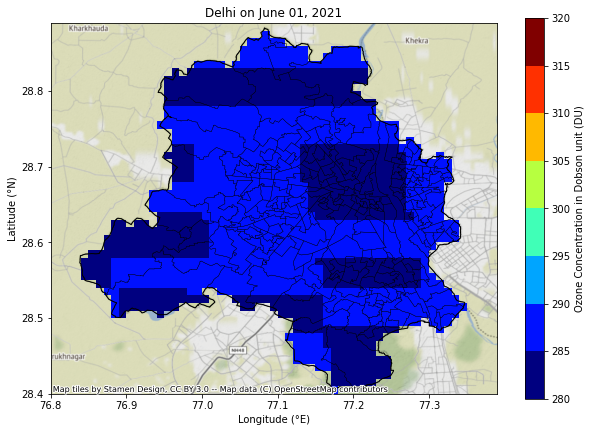

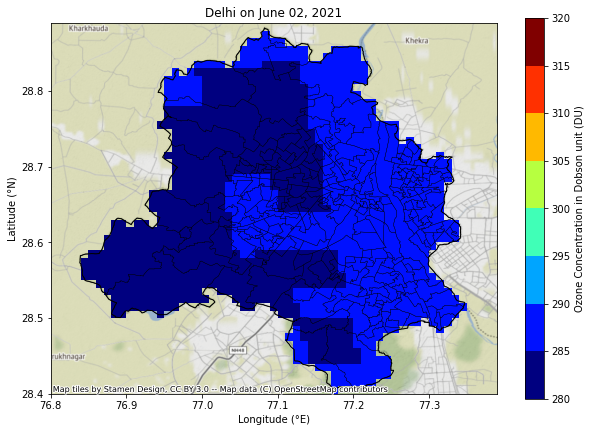

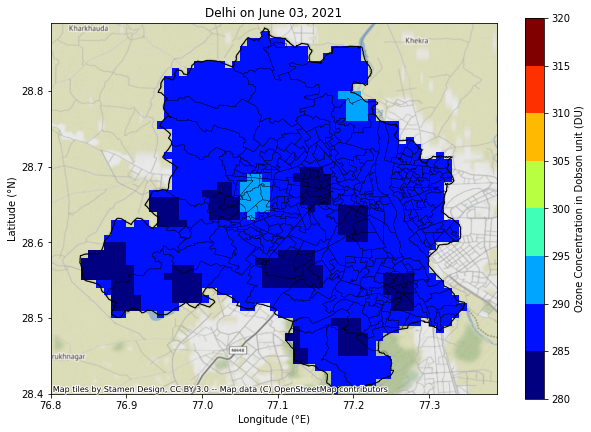

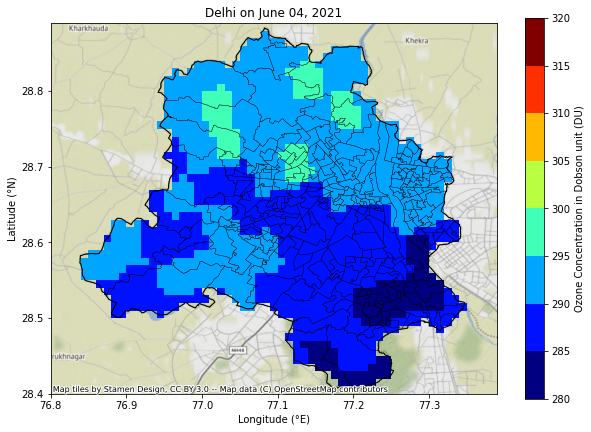

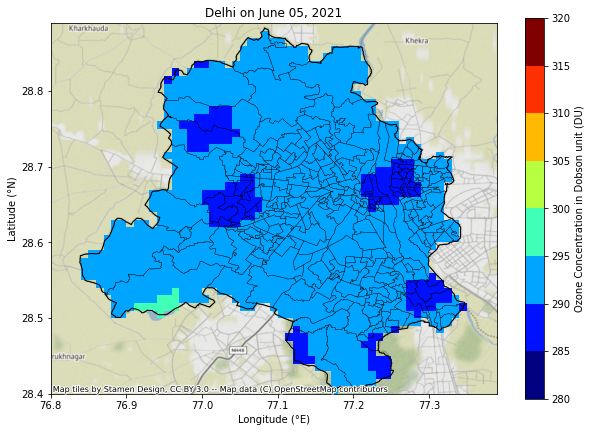

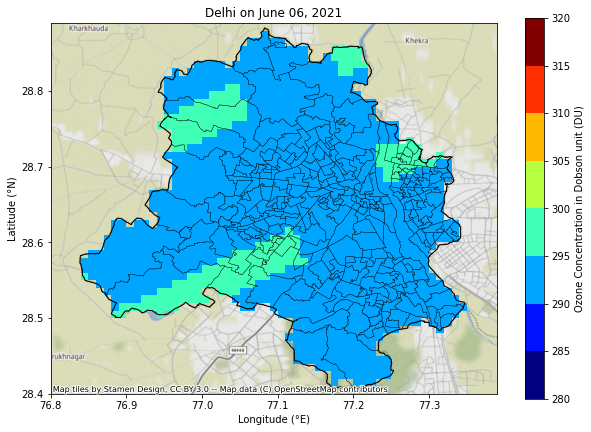

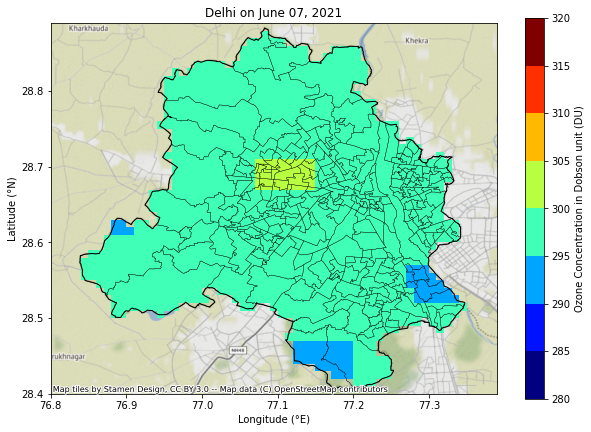

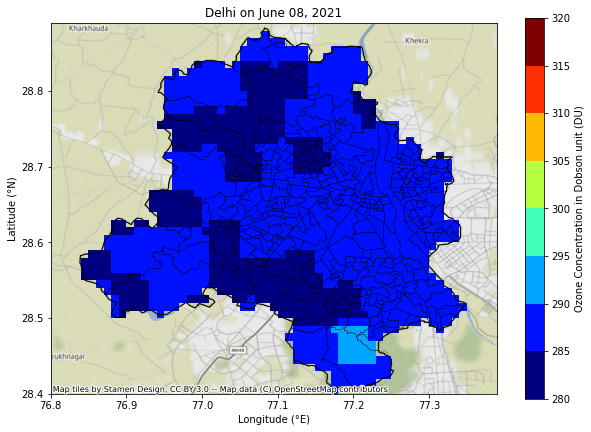

In [23]:
DU_conversion_factor = 2241.15
for i in range(0,len(date_list)):
    merge_path =  'D:\\Ozone\\Lockdown\\Merged\\Merge_'+date_list[i]+'.nc'
    data = xr.open_dataset(merge_path)
    
    O3_data_DU = data['O3_column_number_density'] * DU_conversion_factor 
    O3_data_DU.rio.set_crs(4326)
    clip_is = O3_data_DU.rio.clip(in_shp.geometry.apply(mapping),in_shp.crs,drop=False)
    fig= plt.figure(figsize=(10,7))
    ax = plt.axes()
    clip_is.plot.pcolormesh(levels=9,cmap='jet',cbar_kwargs={'label':'Ozone Concentration in Dobson unit (DU)'},vmax =320,vmin=280)
    
    in_shp.plot(ax=ax,facecolor = 'none')
    ward_shp.plot(ax=ax,facecolor = 'none',linewidth = .3)
    cx.add_basemap(ax=ax , crs='EPSG:4326')
    plt.ylabel('Latitude (°N)')
    plt.xlabel('Longitude (°E)')


    plt.title('Delhi on June '+date_list[i][-2:]+', 2021')
    plt.savefig('D:\\Ozone\\Lockdown\\Plots\\Oz_Jun '+date_list[i][-2:] +'.png',dpi=500)
    plt.show()

In [28]:
image_list = sorted(glob.glob(join('D:\\Ozone\\Lockdown\\Plots\\Oz_*.png')))

In [30]:
images = []
for i in image_list:
    images.append(imageio.imread(i))
imageio.mimsave('D:\\Ozone\\Lockdown\\Plots\\Ozone_Var_Delhi_L.gif',images,fps=5)
    